In this notebook, we will show using [PyNN](http://neuralensemble.org/docs/PyNN/index.html) how a neuron may integrate information by integrating over some tuned receptive field.

In [1]:
import numpy as np

In [2]:
import pyNN.nest as sim
#import pyNN.brian as sim
from pyNN.random import RandomDistribution, NumpyRNG

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/usr/local/lib/python3.7/site-packages/pyNN/nest/__init__.py:55: UserWarning: Unable to install NEST extensions. Certain models may not be available.
Further details: DynamicModuleManagementError in Install: Module 'pynn_extensions' could not be opened.
The dynamic loader returned the following error: 'file not found'.

Please check LD_LIBRARY_PATH (OSX: DYLD_LIBRARY_PATH)!
  warnings.warn("Unable to install NEST extensions. Certain models may not be available.\nFurther details: {}".format(err))


# defining a tuned input


In [3]:
# === Define parameters ========================================================
dt         = 0.5           # (ms)
simtime_show    = 3000.0        # (ms)
simtime    = 20000.0        # (ms)

N_inputs = 60
#N_inputs = 360

lambda_n = 1.5 # (Hz) rate of poisson noise
theta = .50
A = 3.2
B = .61803

In [4]:
def tuning_function(N_inputs, lambda_n=lambda_n, A=A, theta=theta, B=B):
    return lambda_n + A*np.exp((np.cos(2*np.pi*(np.linspace(0, 1, N_inputs)-theta))-1)/B**2)
rate = tuning_function(N_inputs, lambda_n=lambda_n, A=A, theta=theta, B=B)


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig_width = 15
phi = (np.sqrt(5)+1)/2

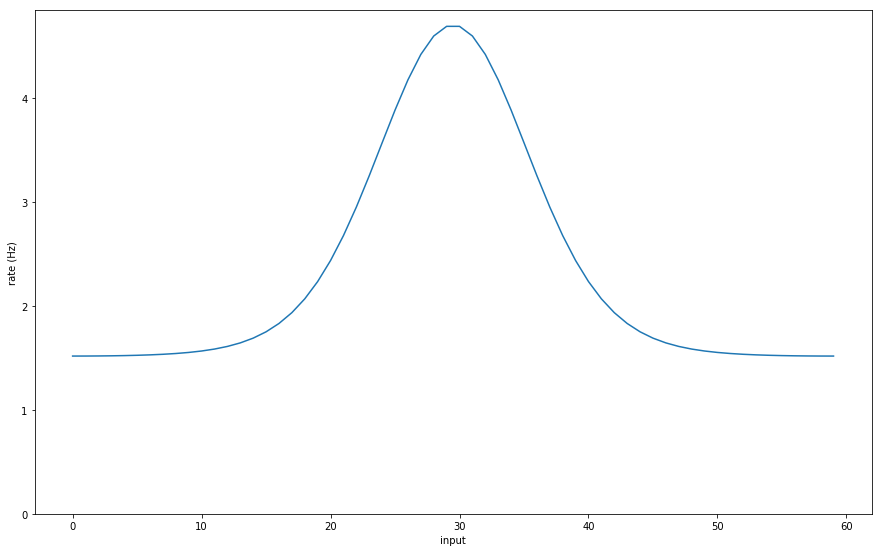

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(rate)
ax.set_ylim(0)
ax.set_xlabel('input')
ax.set_ylabel('rate (Hz)');

In [7]:
from tools import plot_spiketrains
help(plot_spiketrains)

Help on function plot_spiketrains in module tools:

plot_spiketrains(pop, simtime=None, fig=None, ax=None, color='r', markersize=4, verbose=False)
    Plot all spike trains in a Segment in a raster plot.
    
    marker size is in points.



In [8]:
# === Build the network ========================================================
sim.setup(timestep=dt)

spike_input = sim.Population(N_inputs, sim.SpikeSourcePoisson(rate=rate, duration=simtime), label="expoisson")        
spike_input.record('spikes')

# === Run simulation ===========================================================
sim.run(simtime)
sim.end()
#sim.reset()


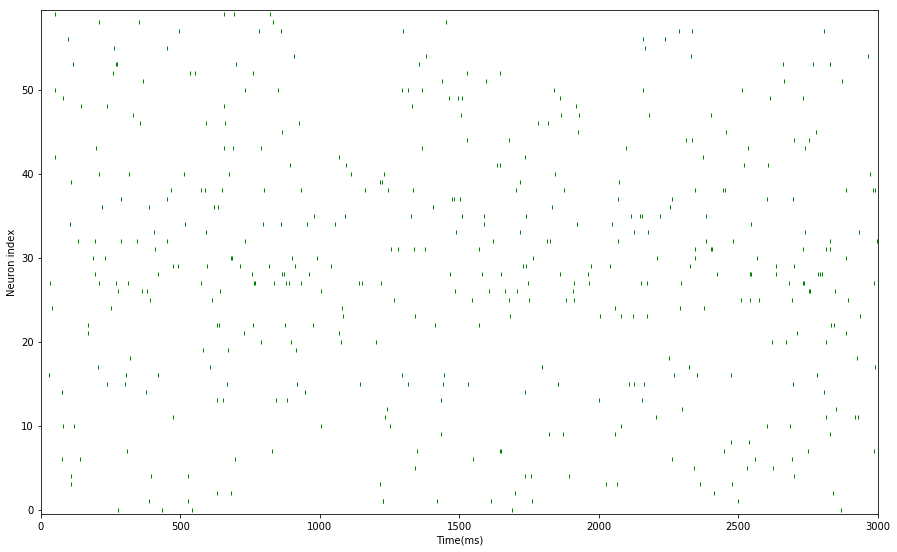

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
fig, ax = plot_spiketrains(spike_input, color='g', simtime=simtime, fig=fig, ax=ax)
#print('sts_in', [list(st.as_array()) for st in sts_in])
ax.set_xlim(0, simtime_show);

Help on function histogram in module tools:

histogram(pop, do_fit=False, fig=None, ax=None, alpha=1.0, color='g', lw=1, label='tc_cells', simtime=None)



(0, 5.4625)

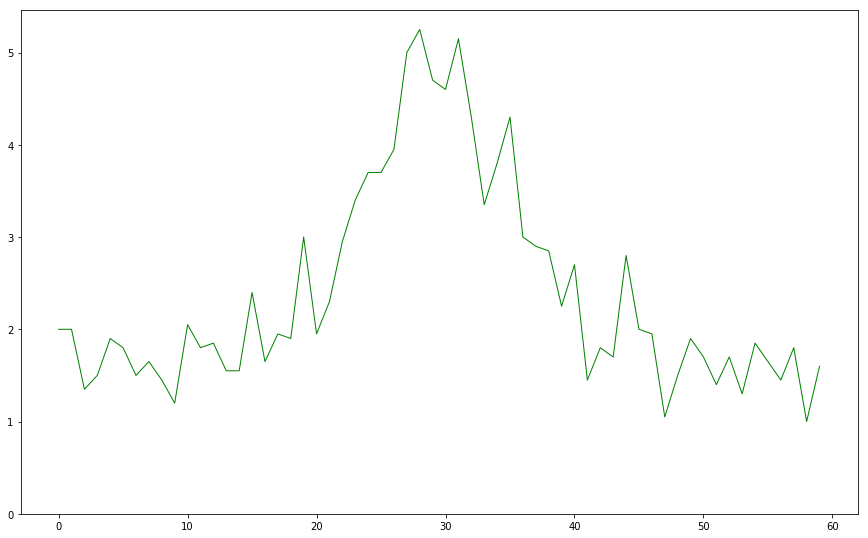

In [10]:
from tools import histogram
help(histogram)

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
fig, ax = histogram(spike_input, color='g', simtime=simtime, fig=fig, ax=ax)
ax.set_ylim(0)

# a spiking neuron is an integrator


In [11]:
weight0 = .6
weights = (weight0 * rate / rate.max())[:, None] * np.linspace(0, 1, N_inputs)[None, :]

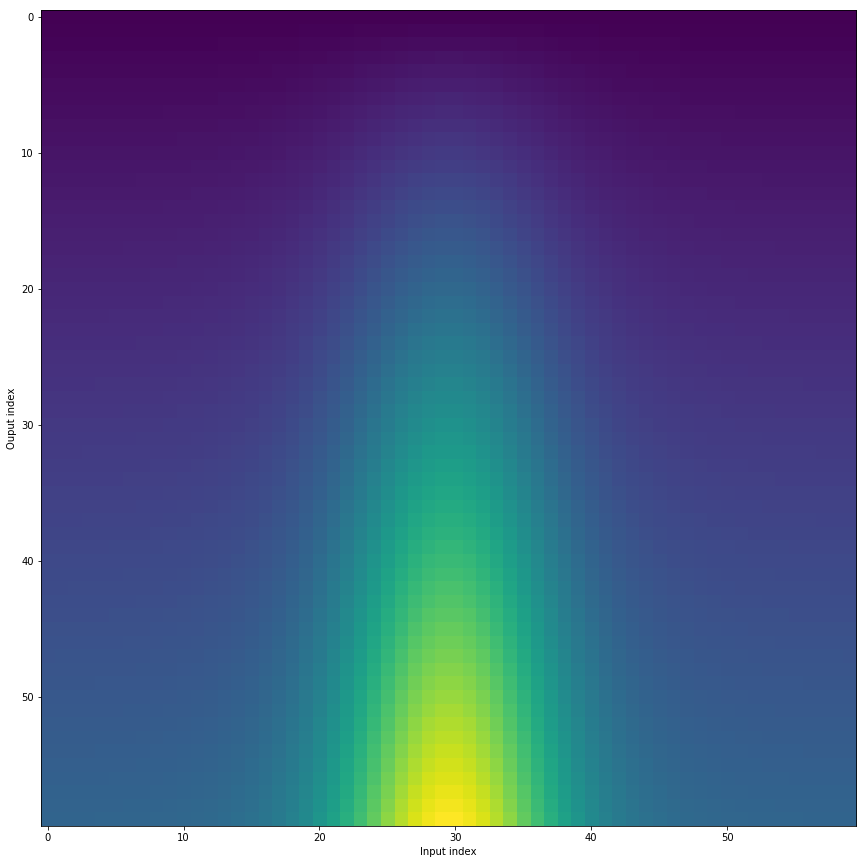

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width))
ax.imshow(weights.T)
ax.set_ylabel("Ouput index")
ax.set_xlabel('Input index');


In [13]:
# === Build the network ========================================================
sim.setup(timestep=dt)

spike_input = sim.Population(N_inputs, sim.SpikeSourcePoisson(rate=rate, duration=simtime), label="expoisson")        
spike_input.record('spikes')

thalamocort_cell = sim.IF_cond_alpha()

tc_cells = sim.Population(N_inputs, thalamocort_cell)
tc_cells.record('spikes')

#Synapses type
delayed_synapses = sim.StaticSynapse()
#connectivity using the projection method
connections = sim.Projection(spike_input, tc_cells,
                                    connector=sim.AllToAllConnector(),
                                    synapse_type=delayed_synapses,
                                    receptor_type='excitatory',
                                    label="excitatory connections")

connections.set(weight=weights)

# === Run simulation ===========================================================
sim.run(simtime)
sim.end()


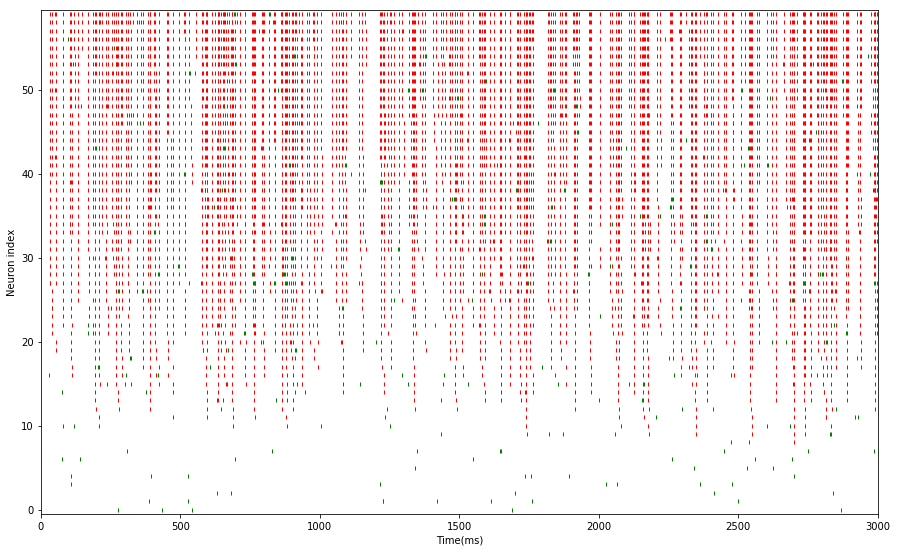

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
fig, ax = plot_spiketrains(spike_input, color='g', simtime=simtime, fig=fig, ax=ax)
fig, ax = plot_spiketrains(tc_cells, color='r', simtime=simtime, fig=fig, ax=ax)
ax.set_xlim(0, simtime_show);

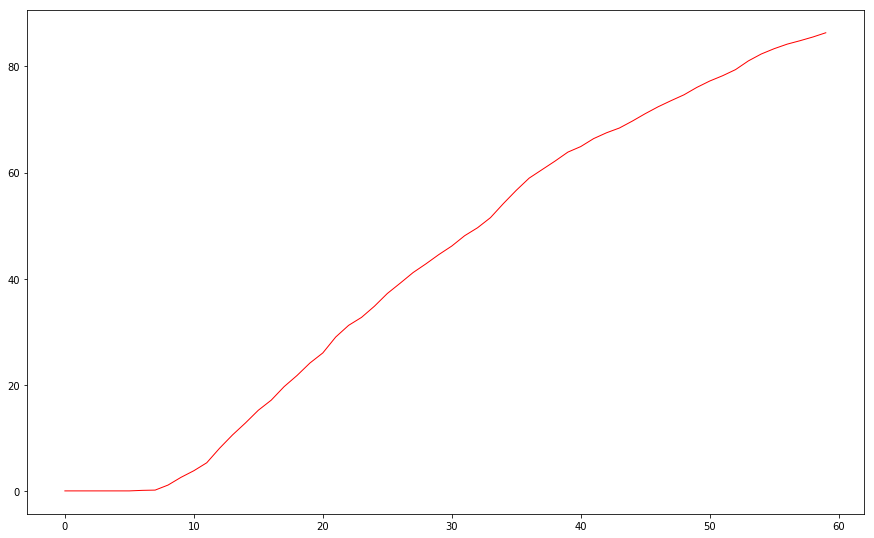

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
#fig, ax = histogram(spike_input, color='g', simtime=simtime, fig=fig, ax=ax)
fig, ax = histogram(tc_cells, color='r', simtime=simtime, fig=fig, ax=ax)

# a spiking neuron is a synchrony detector (or Coincidence detector)

one related set of slides: http://courses.cs.tamu.edu/rgutier/cpsc636_s10/student_presentations/Spiking%20Neuron%20Networks%20Presentation%20for%20PDF.pdf

defining a periodic modulator spike source:

In [16]:
lambda_n = 1.5 # (Hz) rate of poisson noise
theta = .50
A = 30.2
B = .61803
times = np.arange(0.0, simtime, dt)
amp = 1.
amplitudes = amp * (np.sin(times*2*np.pi/200.0) > .8)
rate = tuning_function(N_inputs, lambda_n=lambda_n, A=A, theta=theta, B=B)


In [17]:
# === Build the network ========================================================
sim.setup(timestep=dt)

poisson = sim.Population(N_inputs, sim.SpikeSourcePoisson(rate=rate, duration=simtime))        

buffer = sim.Population(N_inputs, sim.IF_cond_alpha())        

#Synapses type
sine_wave = sim.StepCurrentSource(times=times, amplitudes=amplitudes)
sine_wave.inject_into(buffer) 

buffer.record('spikes')

# === Run simulation ===========================================================
sim.run(simtime)
sim.end()

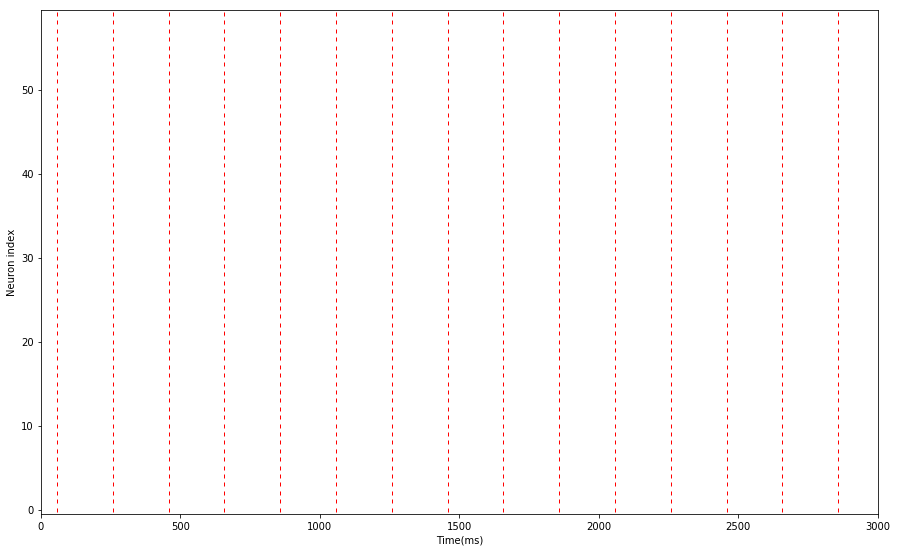

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
#fig, ax = plot_spiketrains(spike_input, color='g', simtime=simtime, fig=fig, ax=ax)
fig, ax = plot_spiketrains(buffer, color='r', simtime=simtime, fig=fig, ax=ax)
#print('sts_in', [list(st.as_array()) for st in sts_in])
ax.set_xlim(0, simtime_show);


defining a synchronously modulated input by injecting this modulator:

In [19]:
# === Build the network ========================================================
sim.setup(timestep=dt)

buffer = sim.Population(N_inputs, sim.IF_cond_alpha())        
sine_wave = sim.StepCurrentSource(times=times, amplitudes=amplitudes)
sine_wave.inject_into(buffer) 

poisson = sim.Population(N_inputs, sim.SpikeSourcePoisson(rate=rate, duration=simtime))        

spike_input = sim.Population(N_inputs, sim.IF_cond_alpha())        

weight = 0.15
modulation = sim.Projection(buffer, spike_input,
                            #connector=sim.AllToAllConnector(),# 
                            #connector=sim.FixedProbabilityConnector(.9),
                            connector=sim.OneToOneConnector(),
                            synapse_type=sim.StaticSynapse(weight=2*weight),
                            receptor_type='excitatory')

connections = sim.Projection(poisson, spike_input,
                            connector=sim.OneToOneConnector(),
                            synapse_type=sim.StaticSynapse(weight=weight),
                            receptor_type='excitatory')

buffer.record('spikes')
spike_input.record('spikes')

# === Run simulation ===========================================================
sim.run(simtime)
sim.end()

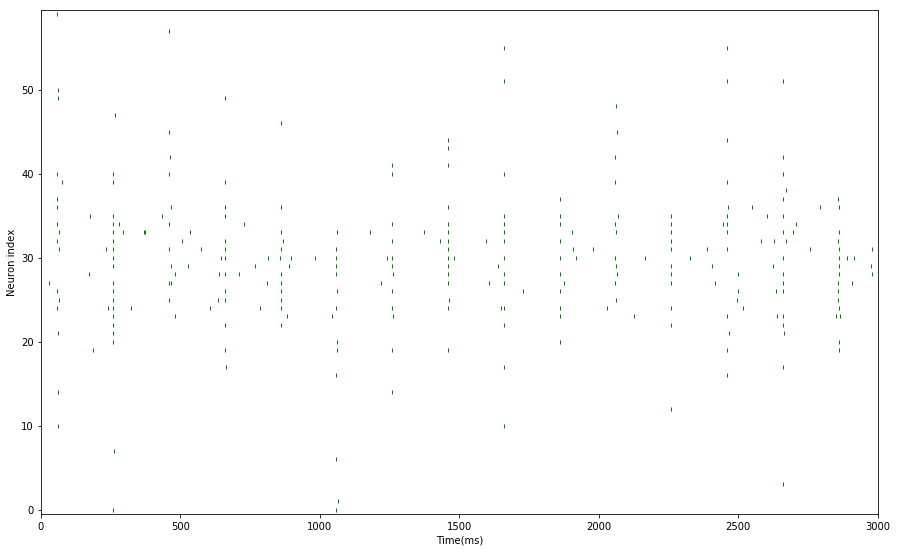

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
fig, ax = plot_spiketrains(spike_input, color='g', simtime=simtime, fig=fig, ax=ax)
#fig, ax = plot_spiketrains(buffer, color='r', simtime=simtime, fig=fig, ax=ax)
#print('sts_in', [list(st.as_array()) for st in sts_in])
ax.set_xlim(0, simtime_show);

Connecting now this synchronous input to integrators with the same weights as above but different delays:

In [21]:
delay0 = 6.
delayB = 25.
std = np.linspace(0, delayB, N_inputs)[None, :] * np.ones((N_inputs, 1))
#delays = delay0 + np.random.lognormal(mean=delay0, sigma=std)
delays = delay0 + np.abs(np.random.normal(loc=0, scale=std))

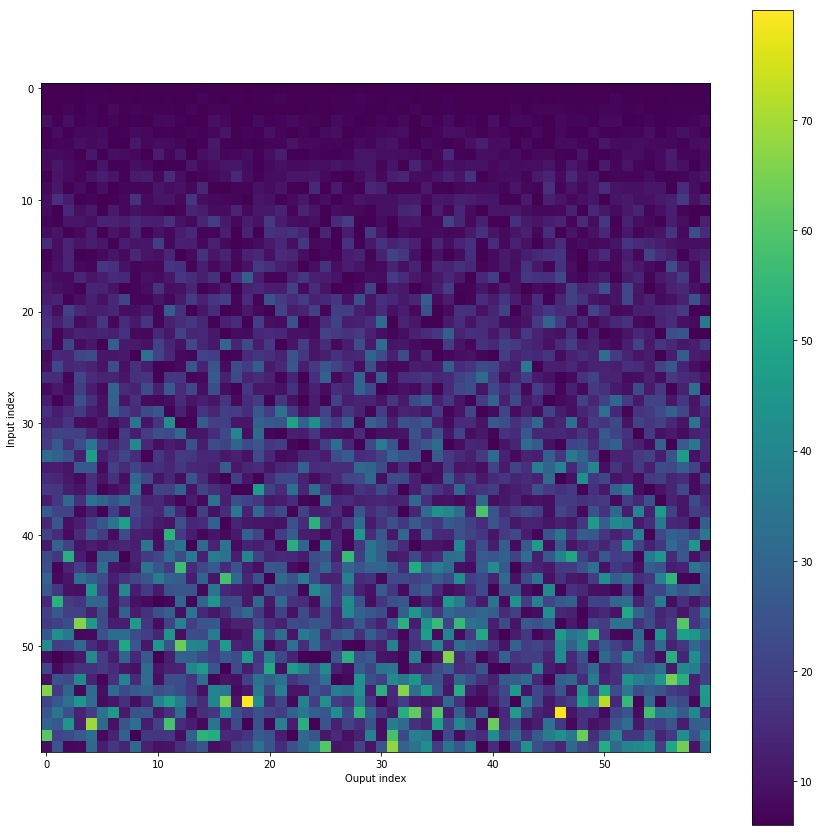

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width))
cmap = ax.imshow(delays.T)
plt.colorbar(cmap)
ax.set_xlabel("Ouput index")
ax.set_ylabel('Input index');

In [23]:
weight0 = .05
weights = (weight0 * rate / rate.max())[:, None] * np.linspace(1, 1, N_inputs)[None, :]

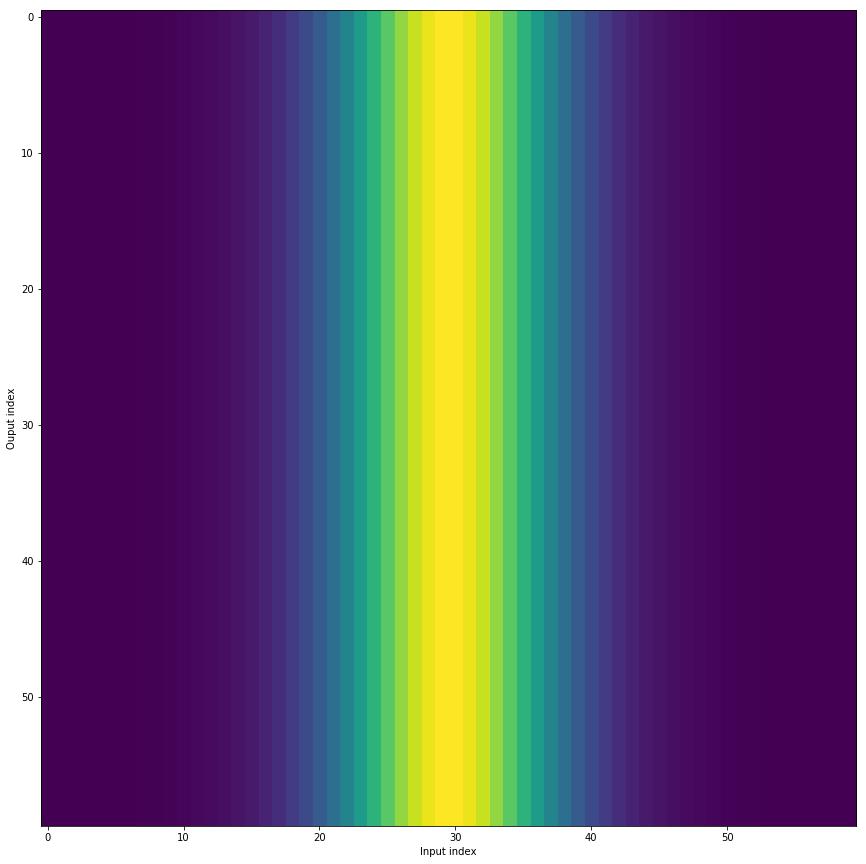

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width))
ax.imshow(weights.T)
ax.set_ylabel("Ouput index")
ax.set_xlabel('Input index');

In [25]:
# === Build the network ========================================================
sim.setup(timestep=dt)

buffer = sim.Population(N_inputs, sim.IF_cond_alpha())        
sine_wave = sim.StepCurrentSource(times=times, amplitudes=amplitudes)
sine_wave.inject_into(buffer) 

poisson = sim.Population(N_inputs, sim.SpikeSourcePoisson(rate=rate, duration=simtime))        
spike_input = sim.Population(N_inputs, sim.IF_cond_alpha())        

modulation = sim.Projection(buffer, spike_input,
                            #connector=sim.AllToAllConnector(),# 
                            #connector=sim.FixedProbabilityConnector(.9),
                            connector=sim.OneToOneConnector(),
                            synapse_type=sim.StaticSynapse(weight=2*weight),
                            receptor_type='excitatory')
input_connector = sim.Projection(poisson, spike_input,
                            connector=sim.OneToOneConnector(),
                            synapse_type=sim.StaticSynapse(weight=weight),
                            receptor_type='excitatory')

spike_input.record('spikes')


thalamocort_cell = sim.IF_cond_alpha()

tc_cells = sim.Population(N_inputs, thalamocort_cell)
tc_cells.record('spikes')

#Synapses type
delayed_synapses = sim.StaticSynapse()
#connectivity using the projection method
connections = sim.Projection(spike_input, tc_cells,
                                    connector=sim.AllToAllConnector(),
                                    synapse_type=delayed_synapses,
                                    receptor_type='excitatory',
                                    label="excitatory connections")

connections.set(weight=weights)
connections.set(delay=delays)

# === Run simulation ===========================================================
sim.run(simtime)
sim.end()


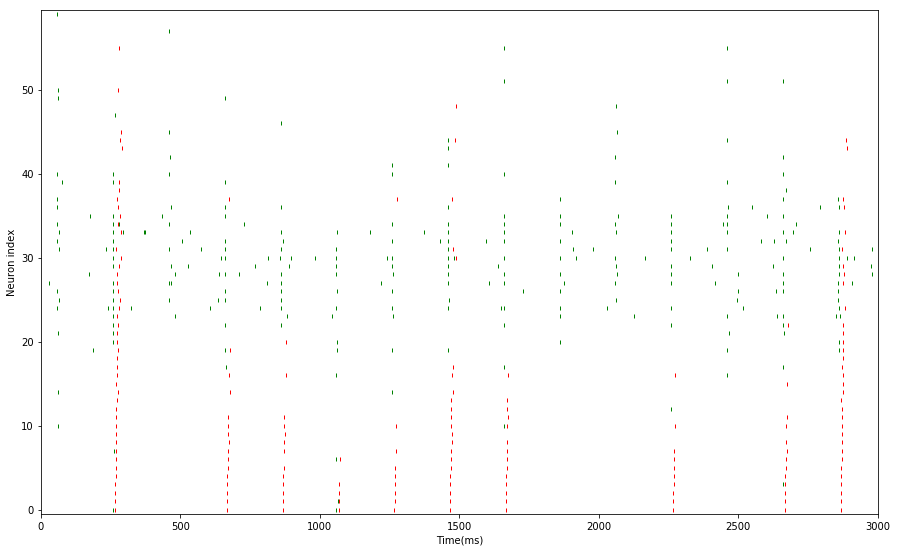

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
fig, ax = plot_spiketrains(spike_input, color='g', simtime=simtime, fig=fig, ax=ax)
fig, ax = plot_spiketrains(tc_cells, color='r', simtime=simtime, fig=fig, ax=ax)
ax.set_xlim(0, simtime_show);

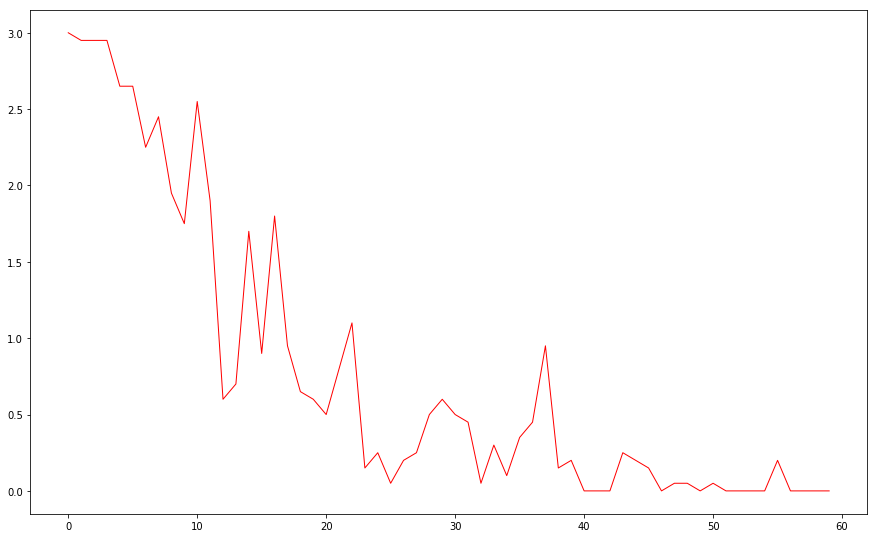

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
#fig, ax = histogram(spike_input, color='g', simtime=simtime, fig=fig, ax=ax)
fig, ax = histogram(tc_cells, color='r', simtime=simtime, fig=fig, ax=ax)

Adding an inhibitory population

In [28]:
delay0 = 2.
delayB = 50.
std = np.linspace(delayB, delayB, N_inputs)[None, :] * np.ones((N_inputs, 1))
#delays = delay0 + np.random.lognormal(mean=delay0, sigma=std)
delays_inh = delay0 + np.abs(np.random.normal(loc=0, scale=std))

In [29]:
# === Build the network ========================================================
sim.setup(timestep=dt)

buffer = sim.Population(N_inputs, sim.IF_cond_alpha())        
sine_wave = sim.StepCurrentSource(times=times, amplitudes=amplitudes)
sine_wave.inject_into(buffer) 

poisson = sim.Population(N_inputs, sim.SpikeSourcePoisson(rate=rate, duration=simtime))        
spike_input = sim.Population(N_inputs, sim.IF_cond_alpha())        

modulation = sim.Projection(buffer, spike_input,
                            connector=sim.OneToOneConnector(),
                            synapse_type=sim.StaticSynapse(weight=2*weight),
                            receptor_type='excitatory')
input_connector = sim.Projection(poisson, spike_input,
                            connector=sim.OneToOneConnector(),
                            synapse_type=sim.StaticSynapse(weight=weight),
                            receptor_type='excitatory')

spike_input.record('spikes')

thalamocort_cell = sim.IF_cond_alpha()

tc_cells_ffi = sim.Population(N_inputs, thalamocort_cell)
tc_cells_ffi.record('spikes')

inh_cells = sim.Population(N_inputs, thalamocort_cell)
inh_cells.record('spikes')

#connectivity using the projection method
connections = sim.Projection(spike_input, tc_cells_ffi,
                            connector=sim.AllToAllConnector(),
                            synapse_type=sim.StaticSynapse(),
                            receptor_type='excitatory')

connections.set(weight=weights)
connections.set(delay=delays)

connections_inh = sim.Projection(spike_input, inh_cells,
                            connector=sim.AllToAllConnector(),
                            synapse_type=sim.StaticSynapse(),
                            receptor_type='excitatory')

connections_inh.set(weight=2*weights)
connections_inh.set(delay=delays_inh)


contrast = sim.Projection(inh_cells, tc_cells_ffi,
                            connector=sim.OneToOneConnector(),
                            synapse_type=sim.StaticSynapse(weight=5.4, delay=1.),
                            receptor_type='inhibitory')

# === Run simulation ===========================================================
sim.run(simtime)
sim.end()


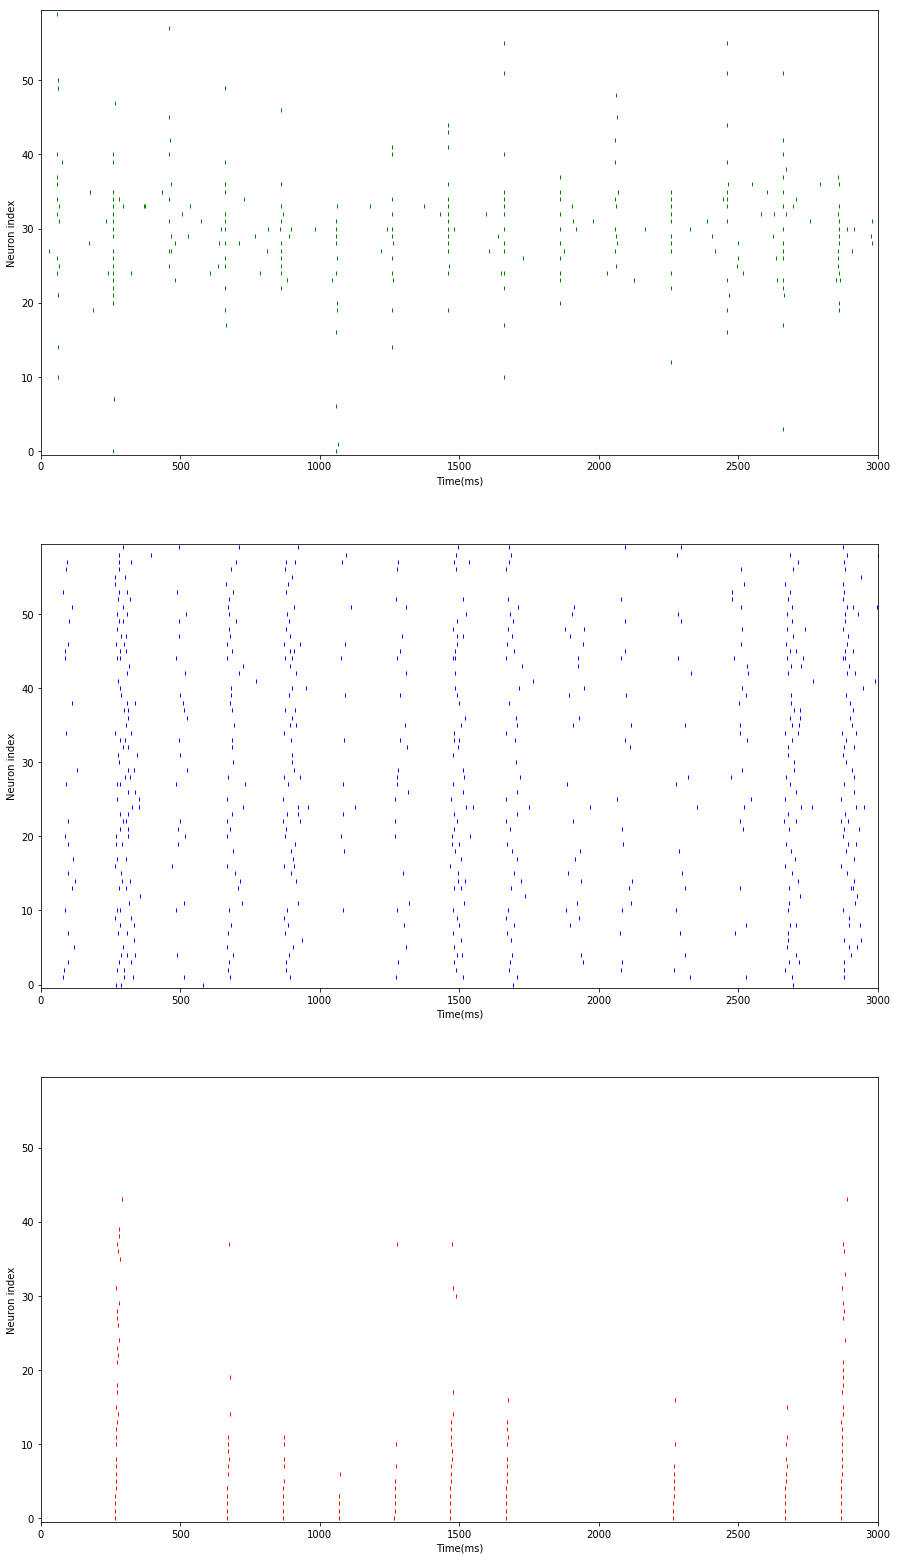

In [30]:
fig, axs = plt.subplots(3, 1, figsize=(fig_width, 3*fig_width/phi))
fig, axs[0] = plot_spiketrains(spike_input, color='g', simtime=simtime, fig=fig, ax=axs[0])
fig, axs[1] = plot_spiketrains(inh_cells, color='b', simtime=simtime, fig=fig, ax=axs[1])
fig, axs[2] = plot_spiketrains(tc_cells_ffi, color='r', simtime=simtime, fig=fig, ax=axs[2])
for ax in axs: ax.set_xlim(0, simtime_show);

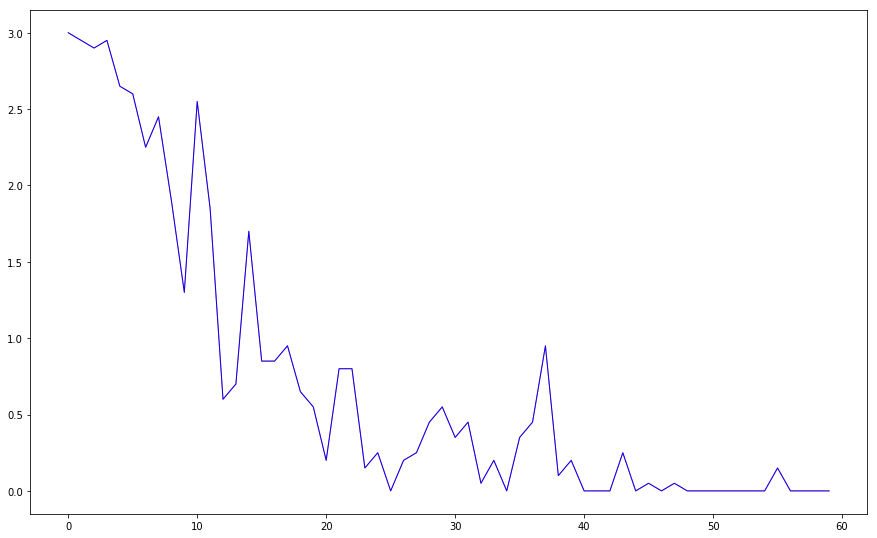

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
#fig, ax = histogram(spike_input, color='g', simtime=simtime, fig=fig, ax=ax)
fig, ax = histogram(tc_cells, color='r', simtime=simtime, fig=fig, ax=ax, alpha=.5)
fig, ax = histogram(tc_cells_ffi, color='b', simtime=simtime, fig=fig, ax=ax)
